In [1]:
# Download dataset
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz 
!rm -r sample_data
!unzip lib.zip -d lib; mv lib/lib lib_; rm -r lib; mv lib_ lib; rm lib.zip

--2020-11-24 13:01:36--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162,60M  6,68MB/s    in 32s     

2020-11-24 13:02:08 (5,13 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
rm: cannot remove 'sample_data': No such file or directory
unzip:  cannot find or open lib.zip, lib.zip.zip or lib.zip.ZIP.
mv: cannot stat 'lib/lib': No such file or directory
mv: cannot 

# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

### Hint for the gradient calculation


<img src="https://i.postimg.cc/zG9h4bKt/net.png">

### Forward pass (vectorized form)

$$z^{[1]} = x^{[0]} W^{[1]} + b^{[1]}$$


$$x^{[1]} = relu\left( z^{[1]} \right)$$


$$z^{[2]} = s = x^{[1]} W^{[2]} + b^{[2]}$$


$$x^{[3]} = p = softmax\left( z^{[2]} \right)$$


$$\mathcal{L} = CE[y, p]$$



### Backward pass

$$\frac{\partial \mathcal{L}}{\partial p_i} = \frac{\partial}{\partial p_i} \Big\{ \ell_i \Big\} = \frac{\partial}{\partial p_i} \Big\{ y_i \log(p_i) \Big\} = - \frac{y_i}{p_i}$$


$$\frac{\partial \mathcal{L}}{\partial s_k} = \sum_i \frac{\partial \mathcal{L}}{\partial p_i} \frac{\partial p_i}{\partial s_k} = - \sum_i \frac{y_i}{p_i} \frac{\partial }{\partial s_k} \left\{ \frac{e^{s_i}}{\sum_l e^{s_l}}  \right\} = - \sum_i \frac{y_i}{p_i} \left[ p_i \left(\delta_{i=k}(1-p_k)\right) - \delta_{i\neq k}p_k) \right] = - \sum_i y_i (\delta_{i=k} - p_k) = p_k - y_k$$


$$\frac{\partial \mathcal{L}}{\partial w_{pk}^{[2]}} = \frac{\partial \mathcal{L}}{\partial s_k} \frac{\partial s_k}{\partial w_{pk}^{[2]}} + 2\lambda w_{pk}^{[2]} = (p_k - y_k) \frac{\partial }{\partial w_{pk}^{[2]}} \left\{ \sum_r x^{[1]}_r w^{[2]}_{rk} +b^{[2]}_k \right\} + 2\lambda w_{pk}^{[2]} + 2\lambda w_{pk}^{[2]} = (p_k - y_k) x^{[1]}_p + 2\lambda w_{pk}^{[2]}$$


$$\frac{\partial \mathcal{L}}{\partial b_{k}^{[2]}} = \frac{\partial \mathcal{L}}{\partial s_k} \frac{\partial s_k}{\partial b_{k}^{[2]}} + 2\lambda b_{k}^{[2]} = (p_k - y_k) \frac{\partial }{\partial b_{k}^{[2]}} \left\{ \sum_r x^{[1]}_r w^{[2]}_{rk} +b^{[2]}_k \right\} + 2\lambda b_{k}^{[2]} = (p_k - y_k) + 2\lambda b_{k}^{[2]} $$

$$\frac{\partial \mathcal{L}}{\partial x_{t}^{[1]}} = \sum_k \frac{\partial \mathcal{L}}{\partial s_k} \frac{\partial s_k}{\partial x_{t}^{[1]}} = \sum_k (p_k - y_k) w^{[2]}_{tk}$$


$$\frac{\partial \mathcal{L}}{\partial z_{t}^{[1]}} = \frac{\partial \mathcal{L}}{\partial x_{t}^{[1]}} \frac{\partial x_{t}^{[1]}}{\partial z_{t}^{[1]}} = \sum_k (p_k - y_k) w^{[2]}_{tk} \mathbb{1}\{ z_{t}^{[1]} \geq 0 \}$$


$$\frac{\partial \mathcal{L}}{\partial w^{[1]}_{mt}} = \frac{\partial \mathcal{L}}{\partial z_{t}^{[1]}} \frac{\partial z_{t}^{[1]}}{\partial w^{[1]}_{mt}} + 2\lambda w_{mt}^{[1]} = \sum_k (p_k - y_k) w^{[2]}_{tk} \mathbb{1}\{ z_{t}^{[1]} \geq 0 \} x^{[0]}_t + 2\lambda w_{mt}^{[1]} $$


$$\frac{\partial \mathcal{L}}{\partial b^{[1]}_{t}} = \frac{\partial \mathcal{L}}{\partial z_{t}^{[1]}} \frac{\partial z_{t}^{[1]}}{\partial b^{[1]}_{t}} + 2\lambda b_{t}^{[1]}  = \sum_k (p_k - y_k) w^{[2]}_{tk} \mathbb{1}\{ z_{t}^{[1]} \geq 0 \} + 2\lambda b_{t}^{[1]} $$


In this lab we need to write these gradients in a vectorial form.

In [53]:
from __future__ import print_function

from builtins import range
from builtins import object
import numpy as np
import matplotlib.pyplot as plt

class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer (scores) - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        Z1 = np.dot(X, W1) + b1 # 1st weighted sum + bias X(N, D) * W1(D, H) + H
        a1 = np.maximum(Z1, 0) # 1st activation layer RELU A1(N, H)
        scores = np.dot(a1, W2) + b2 # 2nd weighted sum + bias  A1(N, H) * W2(H, C) + (C) -> Scores(N, C)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        probs = np.exp(scores) / np.exp(scores).sum(axis=-1, keepdims=True)
        #print( 'Probs shape is ',probs.shape) # 5, 3
        #print(np.arange(probs.shape[-1])) # 0 1 2
        
        #Cost function HAVE A DEEPER LOOK HERE (TODO).
        #First we compute one hot label encoding, (just one bit activation as output), because probs has probabilities as output
        y_oh = np.array([1.0 * (y_i == np.arange(probs.shape[-1])) for y_i in y], dtype=np.float32)
        loss = - np.sum(y_oh * np.log(probs), axis=-1).mean() + reg * (W1**2).sum() + reg * (W2 ** 2).sum() 
        
        pass
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        #Grads are W2, B2; W1, B1
        grads['W2'] = np.dot(a1.T, probs - y_oh) / N  + 2 * reg * W2
        grads['b2'] = np.sum(probs - y_oh, axis=0) / N + 2 * reg * b2
        grads['W1'] = np.dot(X.T, np.dot(probs - y_oh, W2.T) * 1.0 * (Z1 >=0)) / N  + 2 * reg * W1
        grads['b1'] = (np.dot(probs - y_oh, W2.T) * 1.0 * (Z1 >=0)).sum(axis=0) / N  + 2 * reg * b1
        
        pass
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            idx_batch = np.random.randint(num_train, size=batch_size)
            X_batch, y_batch = X[idx_batch], y[idx_batch]
            pass

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            self.params['W1'] = self.params['W1'] - learning_rate * grads['W1']
            self.params['b1'] = self.params['b1'] - learning_rate * grads['b1']
            self.params['W2'] = self.params['W2'] - learning_rate * grads['W2']
            self.params['b2'] = self.params['b2'] - learning_rate * grads['b2']
            pass

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
              'loss_history': loss_history,
              'train_acc_history': train_acc_history,
              'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        a1 = np.maximum(Z1, 0)
        scores = a1.dot(self.params['W2']) + self.params['b2']
        probs = np.exp(scores) / np.exp(scores).sum(axis=-1, keepdims=True)
        y_pred = probs.argmax(axis=-1)
        pass

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred


In [54]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will use the class `TwoLayerNet` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [55]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
The loss function of `TwoLayerNet.loss` takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [56]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularization loss.

In [57]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [58]:
from lib.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447656e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD). Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.02.

Final training loss:  0.017149612521020444


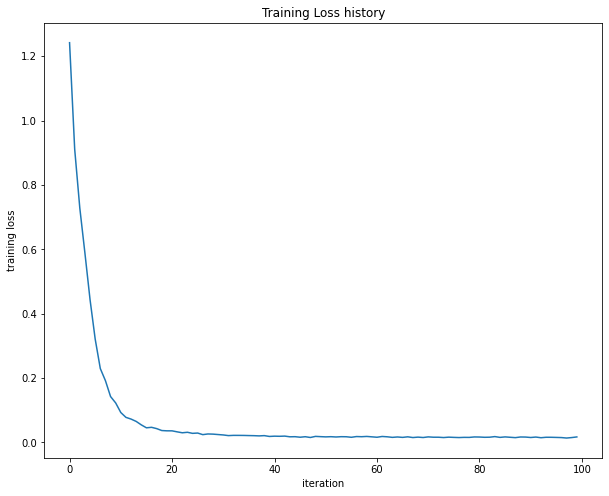

In [59]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [61]:
from lib.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. 
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [62]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


iteration 0 / 1000: loss 2.302954
iteration 100 / 1000: loss 2.302550
iteration 200 / 1000: loss 2.297648
iteration 300 / 1000: loss 2.259602
iteration 400 / 1000: loss 2.204170
iteration 500 / 1000: loss 2.118565
iteration 600 / 1000: loss 2.051535
iteration 700 / 1000: loss 1.988466
iteration 800 / 1000: loss 2.006591
iteration 900 / 1000: loss 1.951473
Validation accuracy:  0.287


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

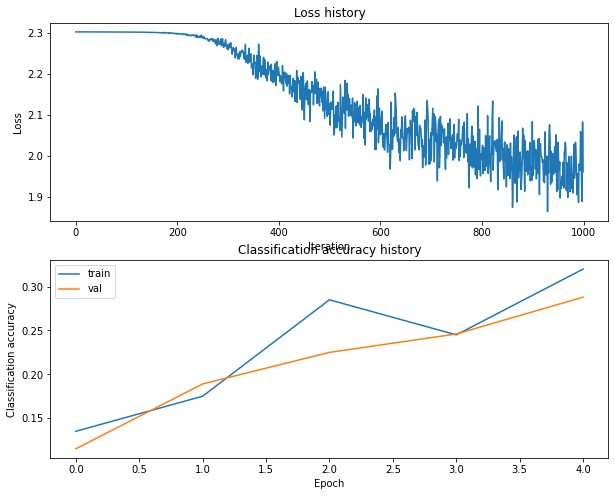

In [63]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

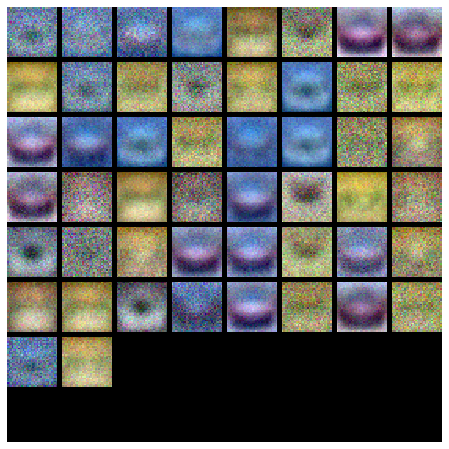

In [64]:
from lib.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

**Explain your hyperparameter tuning process below.**

$\color{blue}{\textit Your Answer:}$

In [65]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
input_size = 32 * 32 * 3
hidden_size = 256
num_classes = 10
best_net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = best_net.train(X_train, y_train, X_val, y_val, num_iters=5000, batch_size=128, learning_rate=5e-4,
                      learning_rate_decay =0.95, reg=0.15, verbose=True)
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 5000: loss 2.303743
iteration 100 / 5000: loss 2.110452
iteration 200 / 5000: loss 1.857221
iteration 300 / 5000: loss 1.778294
iteration 400 / 5000: loss 1.773164
iteration 500 / 5000: loss 1.792946
iteration 600 / 5000: loss 1.589400
iteration 700 / 5000: loss 1.685594
iteration 800 / 5000: loss 1.619548
iteration 900 / 5000: loss 1.694565
iteration 1000 / 5000: loss 1.625134
iteration 1100 / 5000: loss 1.499670
iteration 1200 / 5000: loss 1.713664
iteration 1300 / 5000: loss 1.497765
iteration 1400 / 5000: loss 1.419094
iteration 1500 / 5000: loss 1.522729
iteration 1600 / 5000: loss 1.368834
iteration 1700 / 5000: loss 1.541155
iteration 1800 / 5000: loss 1.420969
iteration 1900 / 5000: loss 1.269335
iteration 2000 / 5000: loss 1.313938
iteration 2100 / 5000: loss 1.372961
iteration 2200 / 5000: loss 1.360153
iteration 2300 / 5000: loss 1.409091
iteration 2400 / 5000: loss 1.402809
iteration 2500 / 5000: loss 1.460607
iteration 2600 / 5000: loss 1.407640
iteration 270

**The best thing to do is define a better learning rate, a smaller one.**

In [66]:
# Print your validation accuracy: this should be above 48%
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

Validation accuracy:  0.502


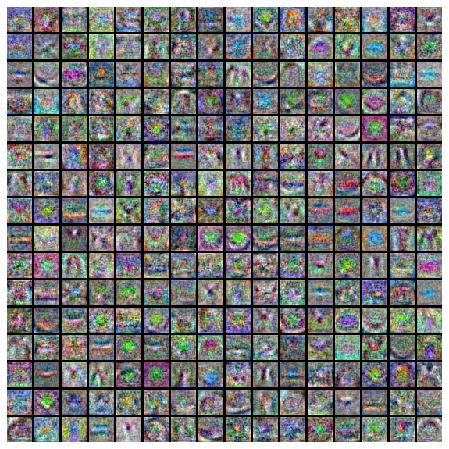

In [67]:
# Visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [68]:
# Print your test accuracy: this should be above 48%
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.512


**Inline Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$ Increase the regularization strength, and larger dataset.

$\color{blue}{\textit Your Explanation:}$

Adding more hidden units I add the probability overfitting the train set.
Instead by increasing the regularization strenght, I add penalizations in the model, in order to restrict the model capacity.
Last but not least, a larger data set would help to not have an overfitted model, since the dataset could be small.

 A Furtherstep that could be done is by changing for example the activation function with a simpler or complex one.